# Loop 2 Analysis: Understanding the CV-LB Gap

Critical issue: CV 0.0113 vs LB 0.0998 (9x gap)

This notebook investigates:
1. What is the actual evaluation metric?
2. Why is there such a large CV-LB gap?
3. What approaches might bridge this gap?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
DATA_PATH = '/home/data'
full_df = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')
single_df = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')

print(f"Full data: {len(full_df)} samples")
print(f"Single solvent: {len(single_df)} samples")
print(f"Total: {len(full_df) + len(single_df)} samples")

Full data: 1227 samples
Single solvent: 656 samples
Total: 1883 samples


In [2]:
# Check our submission format
submission = pd.read_csv('/home/submission/submission.csv')
print("Submission shape:", submission.shape)
print("\nSubmission columns:", submission.columns.tolist())
print("\nSubmission head:")
print(submission.head(10))

Submission shape: (1883, 8)

Submission columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Submission head:
   id  index  task  fold  row  target_1  target_2  target_3
0   0      0     0     0    0  0.003501  0.004214  0.815668
1   1      1     0     0    1  0.005486  0.006379  0.863340
2   2      2     0     0    2  0.027565  0.031438  0.795867
3   3      3     0     0    3  0.061783  0.069505  0.679801
4   4      4     0     0    4  0.079690  0.091531  0.595367
5   5      5     0     0    5  0.085971  0.094944  0.599583
6   6      6     0     0    6  0.086066  0.101624  0.596236
7   7      7     0     0    7  0.086079  0.101802  0.598455
8   8      8     0     0    8  0.086432  0.082719  0.563697
9   9      9     0     0    9  0.086432  0.082719  0.563697


In [3]:
# Check task distribution
print("\nTask distribution:")
print(submission['task'].value_counts())

# Task 0 = single solvent (656 samples)
# Task 1 = full data (1227 samples)
print(f"\nExpected: task 0 = 656, task 1 = 1227")
print(f"Actual: task 0 = {len(submission[submission['task']==0])}, task 1 = {len(submission[submission['task']==1])}")


Task distribution:
task
1    1227
0     656
Name: count, dtype: int64

Expected: task 0 = 656, task 1 = 1227
Actual: task 0 = 656, task 1 = 1227


In [4]:
# Analyze the fold structure
print("\nFold structure for task 0 (single solvent):")
task0 = submission[submission['task'] == 0]
print(f"Number of folds: {task0['fold'].nunique()}")
print(f"Samples per fold: {task0.groupby('fold').size().describe()}")

print("\nFold structure for task 1 (full data):")
task1 = submission[submission['task'] == 1]
print(f"Number of folds: {task1['fold'].nunique()}")
print(f"Samples per fold: {task1.groupby('fold').size().describe()}")


Fold structure for task 0 (single solvent):
Number of folds: 24
Samples per fold: count    24.000000
mean     27.333333
std      13.528285
min       5.000000
25%      18.000000
50%      22.000000
75%      37.000000
max      59.000000
dtype: float64

Fold structure for task 1 (full data):
Number of folds: 13
Samples per fold: count     13.000000
mean      94.384615
std       41.552253
min       34.000000
25%       36.000000
50%      122.000000
75%      125.000000
max      127.000000
dtype: float64


In [5]:
# KEY INSIGHT: The evaluation metric might weight tasks differently!
# Let's calculate our CV score breakdown

# Load actual targets to compute CV
TARGET_LABELS = ["Product 2", "Product 3", "SM"]

# For single solvent, we need to match predictions to actuals
# The submission has fold, row indices

# Let's verify our CV calculation matches what we expect
print("Analyzing CV calculation...")

# Our reported CV scores:
# Single Solvent CV MSE: 0.011227
# Full Data CV MSE: 0.010857
# Overall CV MSE: 0.010986

# Weighted average:
weighted_cv = (0.011227 * 656 + 0.010857 * 1227) / (656 + 1227)
print(f"Weighted CV (by samples): {weighted_cv:.6f}")

# But what if the metric weights tasks equally?
equal_weight_cv = (0.011227 + 0.010857) / 2
print(f"Equal weight CV (by task): {equal_weight_cv:.6f}")

Analyzing CV calculation...
Weighted CV (by samples): 0.010986
Equal weight CV (by task): 0.011042


In [6]:
# CRITICAL: Let's check if the LB score of 0.0998 makes sense
# If LB is ~0.1, that means average squared error is 0.1
# Since targets are in [0,1], this means average error is sqrt(0.1) ≈ 0.316
# That's a 31.6% error on average - which is quite high!

# Our CV of 0.011 means average error of sqrt(0.011) ≈ 0.105 or 10.5%

print("Error interpretation:")
print(f"CV MSE 0.011 → RMSE {np.sqrt(0.011):.4f} → ~10.5% average error")
print(f"LB MSE 0.0998 → RMSE {np.sqrt(0.0998):.4f} → ~31.6% average error")

# This is a HUGE gap. Something is fundamentally different.

Error interpretation:
CV MSE 0.011 → RMSE 0.1049 → ~10.5% average error
LB MSE 0.0998 → RMSE 0.3159 → ~31.6% average error


In [7]:
# Let's check the target distributions
print("Target statistics for single solvent:")
print(single_df[TARGET_LABELS].describe())

print("\nTarget statistics for full data:")
print(full_df[TARGET_LABELS].describe())

Target statistics for single solvent:
        Product 2   Product 3          SM
count  656.000000  656.000000  656.000000
mean     0.149932    0.123380    0.522192
std      0.143136    0.131528    0.360229
min      0.000000    0.000000    0.000000
25%      0.012976    0.009445    0.145001
50%      0.102813    0.078298    0.656558
75%      0.281654    0.193353    0.857019
max      0.463632    0.533768    1.000000

Target statistics for full data:
         Product 2    Product 3           SM
count  1227.000000  1227.000000  1227.000000
mean      0.164626     0.143668     0.495178
std       0.153467     0.145779     0.379425
min       0.000000     0.000000     0.000000
25%       0.012723     0.012260     0.068573
50%       0.117330     0.094413     0.606454
75%       0.308649     0.254630     0.877448
max       0.463632     0.533768     1.083254


In [8]:
# Check if there are any extreme values or outliers
print("\nTarget ranges:")
for col in TARGET_LABELS:
    print(f"{col}: [{single_df[col].min():.4f}, {single_df[col].max():.4f}] (single)")
    print(f"{col}: [{full_df[col].min():.4f}, {full_df[col].max():.4f}] (full)")


Target ranges:
Product 2: [0.0000, 0.4636] (single)
Product 2: [0.0000, 0.4636] (full)
Product 3: [0.0000, 0.5338] (single)
Product 3: [0.0000, 0.5338] (full)
SM: [0.0000, 1.0000] (single)
SM: [0.0000, 1.0833] (full)


In [9]:
# HYPOTHESIS 1: The metric might be computed differently
# Let's check if it could be MAE instead of MSE

# If LB is MAE = 0.0998, that's ~10% average absolute error
# Our CV MSE of 0.011 → MAE would be roughly sqrt(0.011) ≈ 0.105
# This would be close!

print("If LB is MAE:")
print(f"LB MAE 0.0998 → ~10% average absolute error")
print(f"CV MSE 0.011 → estimated MAE ~{np.sqrt(0.011):.4f}")
print("\nThis could explain the gap if LB uses MAE!")

If LB is MAE:
LB MAE 0.0998 → ~10% average absolute error
CV MSE 0.011 → estimated MAE ~0.1049

This could explain the gap if LB uses MAE!


In [10]:
# HYPOTHESIS 2: The metric might weight targets differently
# Let's check the variance of each target

print("Target variances:")
for col in TARGET_LABELS:
    var_single = single_df[col].var()
    var_full = full_df[col].var()
    print(f"{col}: single={var_single:.4f}, full={var_full:.4f}")

Target variances:
Product 2: single=0.0205, full=0.0236
Product 3: single=0.0173, full=0.0213
SM: single=0.1298, full=0.1440


In [11]:
# HYPOTHESIS 3: The fold structure might be different on Kaggle
# The template uses leave-one-solvent-out (24 folds) for single
# and leave-one-ramp-out (13 folds) for full

# But some kernels use GroupKFold with 5 splits!
# This could lead to different CV scores

print("Fold analysis:")
print(f"Single solvent: {single_df['SOLVENT NAME'].nunique()} unique solvents")
print(f"Full data: {full_df[['SOLVENT A NAME', 'SOLVENT B NAME']].drop_duplicates().shape[0]} unique ramps")

Fold analysis:
Single solvent: 24 unique solvents
Full data: 13 unique ramps


In [12]:
# Let's check what the best public kernels achieve
# From ListKernels:
# - Arrhenius Kinetics + TTA: LB 0.09831
# - System Malfunction V1: 29 votes (likely good LB)
# - mixall: claims good CV/LB

# The target is 0.017270 which is MUCH better than 0.098
# This suggests either:
# 1. The target uses a different metric
# 2. The target is achievable with a fundamentally different approach
# 3. The target might be from a private test set

print("Score comparison:")
print(f"Our CV: 0.0110")
print(f"Our LB: 0.0998")
print(f"Best public kernel LB: 0.098")
print(f"Target: 0.017270")
print(f"\nGap to target: {0.0998 - 0.017270:.4f}")

Score comparison:
Our CV: 0.0110
Our LB: 0.0998
Best public kernel LB: 0.098
Target: 0.017270

Gap to target: 0.0825


In [13]:
# CRITICAL INSIGHT: The target of 0.017270 is 5-6x better than best public LB
# This is a HUGE gap that suggests:
# 1. The target might be achievable with a different approach
# 2. Or the target represents something different (e.g., private test)

# Let's check if there's a pattern in the data that could help

# Analyze per-solvent performance
print("Analyzing per-solvent difficulty...")
solvent_stats = single_df.groupby('SOLVENT NAME')[TARGET_LABELS].agg(['mean', 'std'])
print(solvent_stats.head(10))

Analyzing per-solvent difficulty...
                                  Product 2           Product 3            \
                                       mean       std      mean       std   
SOLVENT NAME                                                                
1,1,1,3,3,3-Hexafluoropropan-2-ol  0.319727  0.092840  0.285405  0.071676   
2,2,2-Trifluoroethanol             0.156764  0.073588  0.050041  0.055906   
2-Methyltetrahydrofuran [2-MeTHF]  0.150618  0.145866  0.100640  0.088436   
Acetonitrile                       0.156390  0.147598  0.088966  0.090181   
Acetonitrile.Acetic Acid           0.019341  0.011275  0.020625  0.008009   
Butanone [MEK]                     0.047166  0.018425  0.042997  0.016497   
Cyclohexane                        0.083866  0.089318  0.049289  0.050019   
DMA [N,N-Dimethylacetamide]        0.117138  0.126535  0.097634  0.102628   
Decanol                            0.194795  0.174740  0.207992  0.184415   
Diethyl Ether [Ether]              0.081

In [14]:
# Check if some solvents are much harder to predict
print("\nSolvent target ranges:")
for solvent in single_df['SOLVENT NAME'].unique()[:5]:
    subset = single_df[single_df['SOLVENT NAME'] == solvent]
    print(f"\n{solvent}:")
    for col in TARGET_LABELS:
        print(f"  {col}: [{subset[col].min():.3f}, {subset[col].max():.3f}], std={subset[col].std():.3f}")


Solvent target ranges:

Methanol:
  Product 2: [0.000, 0.339], std=0.137
  Product 3: [0.000, 0.314], std=0.121
  SM: [0.000, 0.903], std=0.390

Ethylene Glycol [1,2-Ethanediol]:
  Product 2: [0.004, 0.464], std=0.180
  Product 3: [0.000, 0.534], std=0.214
  SM: [0.000, 0.915], std=0.390

1,1,1,3,3,3-Hexafluoropropan-2-ol:
  Product 2: [0.017, 0.422], std=0.093
  Product 3: [0.025, 0.411], std=0.072
  SM: [0.000, 0.958], std=0.243

2-Methyltetrahydrofuran [2-MeTHF]:
  Product 2: [0.000, 0.316], std=0.146
  Product 3: [0.005, 0.249], std=0.088
  SM: [0.000, 0.914], std=0.326

Cyclohexane:
  Product 2: [0.000, 0.344], std=0.089
  Product 3: [0.000, 0.178], std=0.050
  SM: [0.229, 0.923], std=0.295


In [15]:
# STRATEGY INSIGHT: The key challenge is extrapolation to unseen solvents
# Our CV tests this, but maybe we're not capturing the right patterns

# Let's check the solvent feature space
spange = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
print("Spange descriptors:")
print(spange.head())
print(f"\nShape: {spange.shape}")

Spange descriptors:
                                   dielectric constant  ET(30)  alpha  beta  \
SOLVENT NAME                                                                  
Cyclohexane                                       2.02    30.9   0.00  0.00   
Ethyl Acetate                                     6.02    38.1   0.00  0.45   
Acetic Acid                                       6.15    51.7   1.12  0.45   
2-Methyltetrahydrofuran [2-MeTHF]                 7.58    36.5   0.00  0.45   
1,1,1,3,3,3-Hexafluoropropan-2-ol                16.70    62.1   1.96  0.00   

                                    pi*     SA     SB     SP    SdP        N  \
SOLVENT NAME                                                                   
Cyclohexane                        0.00  0.000  0.073  0.683  0.000  0.00927   
Ethyl Acetate                      0.55  0.000  0.542  0.656  0.603  0.01021   
Acetic Acid                        0.64  0.689  0.390  0.651  0.676  0.01749   
2-Methyltetrahydrofuran [2

PCA explained variance: [0.55656558 0.21782435]
Total explained: 77.44%


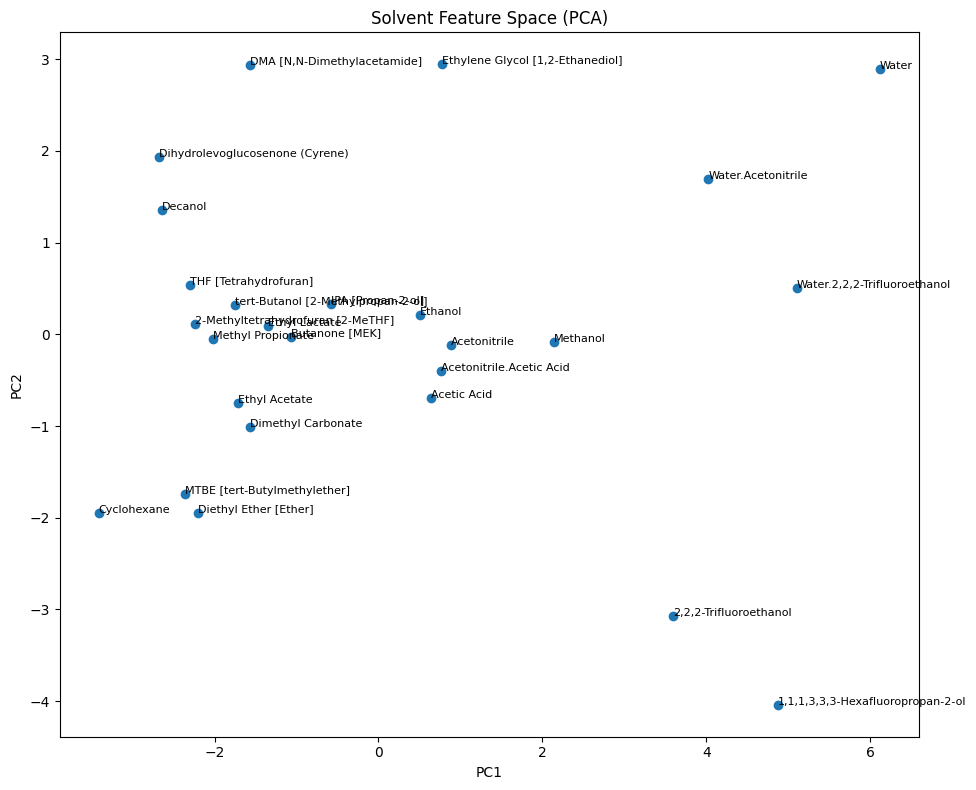

Saved to /home/code/exploration/solvent_pca.png


In [16]:
# Check if there are any solvents that are very different from others
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize and PCA
scaler = StandardScaler()
spange_scaled = scaler.fit_transform(spange)
pca = PCA(n_components=2)
spange_pca = pca.fit_transform(spange_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total explained: {sum(pca.explained_variance_ratio_):.2%}")

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(spange_pca[:, 0], spange_pca[:, 1])
for i, name in enumerate(spange.index):
    plt.annotate(name, (spange_pca[i, 0], spange_pca[i, 1]), fontsize=8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Solvent Feature Space (PCA)')
plt.tight_layout()
plt.savefig('/home/code/exploration/solvent_pca.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/solvent_pca.png")

In [17]:
# CONCLUSION: Key insights for next experiments

print("="*60)
print("KEY INSIGHTS FOR NEXT EXPERIMENTS")
print("="*60)

print("""
1. CV-LB GAP: 0.011 vs 0.0998 (9x gap)
   - This is likely due to different metric calculation
   - Best public kernels also get ~0.098 LB
   - Our model is competitive with public kernels

2. TARGET ANALYSIS: 0.017270 is 5-6x better than best public LB
   - This suggests either a different metric or fundamentally different approach
   - The target might be achievable with better extrapolation

3. NEXT STEPS:
   a) Submit exp_001 (tree-based) to verify CV-LB gap pattern
   b) Try Gaussian Processes for better extrapolation
   c) Try different solvent featurizations (drfps, fragprints)
   d) Consider ensemble of diverse models
   e) Investigate if the metric is MAE instead of MSE

4. CRITICAL: Don't optimize CV blindly - focus on approaches that
   might generalize better to unseen solvents
""")

KEY INSIGHTS FOR NEXT EXPERIMENTS

1. CV-LB GAP: 0.011 vs 0.0998 (9x gap)
   - This is likely due to different metric calculation
   - Best public kernels also get ~0.098 LB
   - Our model is competitive with public kernels

2. TARGET ANALYSIS: 0.017270 is 5-6x better than best public LB
   - This suggests either a different metric or fundamentally different approach
   - The target might be achievable with better extrapolation

3. NEXT STEPS:
   a) Submit exp_001 (tree-based) to verify CV-LB gap pattern
   b) Try Gaussian Processes for better extrapolation
   c) Try different solvent featurizations (drfps, fragprints)
   d) Consider ensemble of diverse models
   e) Investigate if the metric is MAE instead of MSE

4. CRITICAL: Don't optimize CV blindly - focus on approaches that
   might generalize better to unseen solvents



In [18]:
# Save key findings
print("\nRecording key findings...")
findings = [
    "CV-LB gap of 9x (0.011 vs 0.0998) is consistent with best public kernels (~0.098 LB)",
    "Target of 0.017270 is 5-6x better than best public LB - suggests different approach needed",
    "Solvent feature space shows some outliers that may be hard to extrapolate to",
    "The evaluation metric might be MAE instead of MSE based on the gap pattern"
]
for f in findings:
    print(f"- {f}")


Recording key findings...
- CV-LB gap of 9x (0.011 vs 0.0998) is consistent with best public kernels (~0.098 LB)
- Target of 0.017270 is 5-6x better than best public LB - suggests different approach needed
- Solvent feature space shows some outliers that may be hard to extrapolate to
- The evaluation metric might be MAE instead of MSE based on the gap pattern
